# Ch7. 앙상블 학습과 랜덤 포레스트

- 일련의 예측기(분류나 회귀 모델)로부터 예측을 수집하면 가장 좋은 모델 하나보다 더 좋은 예측을 얻을 수 있음.
- 일련의 예측기를 **앙상블** 이라 함.
- 훈련 세트로부터 무작위로 각기 다른 서브셋을 만들어 일련의 결정 트리 분류기를 훈련시킬 수 있음.
- 예측을 하려면 모든 개별 트리의 예측을 구하면 됨.
- 그 다음 가장 많은 선택을 받은 클래스를 예측으로 삼음
- 결정 트리의 앙상블을 **랜덤 포레스트** 라고 함.
- 추가로 배깅, 부스팅, 스태킹 등 인기 있는 앙상블이 있음.

## 7.1 투표 기반 분류기

- 더 좋은 분류기를 만드는 매우 간단한 방법은 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것
- 다수결 투표로 정해지는 분류기를 **직접 투표** 분류기라고 함.
- 각 분류기가 **약한 학습기** 일지라도 충분하게 많고 다양하다면 앙상블은 **강한 학습기** 가 될 수 있음.

In [2]:
import warnings
warnings.filterwarnings('ignore')

# import package
import numpy as np
import os

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X, y = make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [5]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.85
RandomForestClassifier 1.0
SVC 0.95
VotingClassifier 0.95


## 7.2 배깅과 페이스팅

- 훈련 세트에서 중복을 허용하여 샘플링하는 방식을 **배깅**
- 중복을 허용하지 않고 샘플링하는 방식을 **페이스팅**
- 배깅과 페이스팅에서는 같은 훈련 샘플을 여러 개의 예측기에 걸쳐 사용 가능
- 배깅만이 한 예측기를 위해 같은 훈련 샘플을 여러 번 샘플링 가능

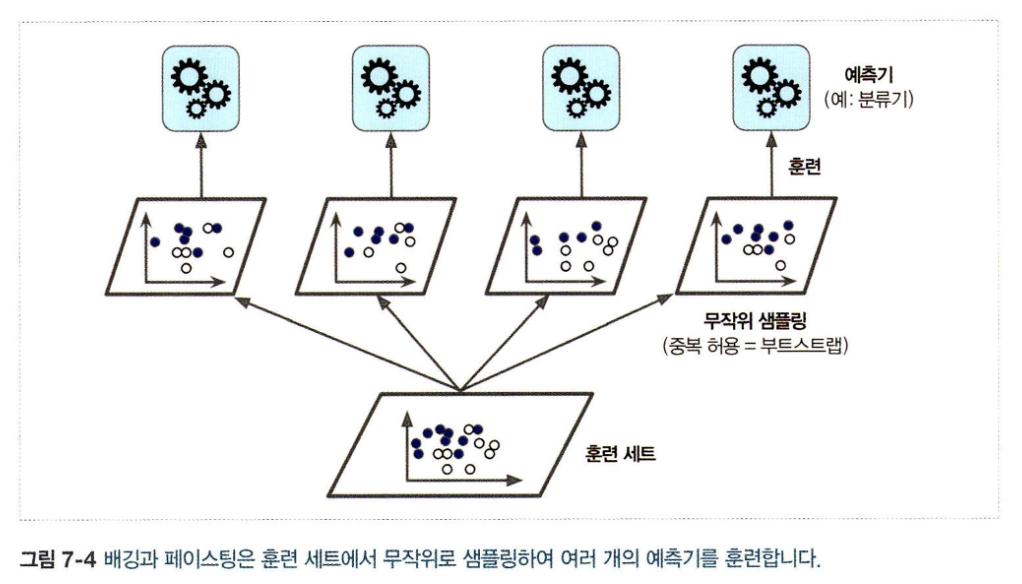

### 7.2.1 사이킷런의 배깅과 페이스팅

- 간편한 API로 구성된 BaggingClassifier(회귀의 경우에는 BaggingRegressor)를 제공
- 페이스팅 사용하려면 bootstrap=Flase로 지정
- n_jobs 매개변수는 사이킷런이 훈련과 예측에 사용할 CPU 코어 수 지정(-1로 지정 시 가용한 모든 코어 사용)

In [6]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=50, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

### 7.2.2 obb 평가

- 배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러 번 샘플링되고 어떤 것은 전혀 선택되지 않을 수 있음.
- BaggingClassifier는 기본값으로 중복을 허용하여(bootstrap=True) 훈련 세트의 크기만틈인 m개 샘플ㅇ르 선택
- 이는 평균적으로 각 예측기에 훈련 샘플의 63% 정도만 샘플링됨을 의미
- 선택되지 않은 훈련 샘플의 나머지 37%를 oob(out-of-bag) 샘플. 예측기마다 남겨진 37%는 모두 다름.

In [8]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8875

In [9]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

1.0

In [10]:
bag_clf.oob_decision_function_

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [0.9375    , 0.0625    ],
       [0.13068182, 0.86931818],
       [1.        , 0.        ],
       [0.00943396, 0.99056604],
       [0.03108808, 0.96891192],
       [1.        , 0.        ],
       [0.01162791, 0.98837209],
       [0.        , 1.        ],
       [0.46666667, 0.53333333],
       [1.        , 0.        ],
       [0.89189189, 0.10810811],
       [0.91566265, 0.08433735],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.56287425, 0.43712575],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.05142857, 0.94857143],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.98863636, 0.01136364],
       [0.82258065, 0.17741935],
       [0.07065217, 0.92934783],
       [1.        , 0.        ],
       [0.64      , 0.36      ],
       [0.36649215, 0.63350785],
       [0.        , 1.        ],
       [1.

## 7.3 랜덤 패치와 랜덤 서브스페이스

- BaggingClassifier는 특정 샘플링 지원
- 샘플링은 max_features, bootstrap_feature 두 매개변수로 조절
- 작동 방식은 max_samples, bootstrap과 동일하지만 샘플이 아니고 특성에 대한 샘플링
- 따라서 각 예측기는 무작위로 선택한 입력 특성의 일부분으로 훈련됨

- **랜덤 패치 방식** : 훈련 특성과 샘플을 모두 샘플링하는 것
- **랜덤 서브스페이스 방식** : 훈련 샘플을 모두 사용하고(bootstrap=False이고 max_samples=1.0로 설정) 특성은 샘플링하는(bootstrap_features=True 그리고/또는 max_features는 1.0보다 작게 설정) 것
- 특정 샘플링은 더 다양한 예측기를 만들며 편향을 늘리는 대신 분산을 낮춤.

## 7.4 랜덤 포레스트

- 전형적으로 max_samples를 훈련 세트의 크기로 지정
- BaggingClassifier에 DecisionTreeClassifier를 넣어 만드는 대신 결정 트리에 최적화되어 사용하기 편리한 RandomForestClassifier를 사용 가능

In [12]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [15]:
# 트리를 더욱 다양하게 만들고 편향을 손해보는 대신 분산을 낮추어 전체적으로 더 훌륭한 모델을 만듦.
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="auto", max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

### 7.4.1 엑스트라 트리

- 트리를 더 무작위하게 만들기 위해 최적의 임곗값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음 그중에서 최상의 분할 선택
- **익스트림 랜덤 트리 앙상블(또는 엑스트라 트리)** : 극단적으로 무작위한 트리의 랜덤 포레스트, 편향이 늘어나는 대신 분산 낮춤.
- 모든 노드에서 특성마다 가장 최적의 임곗값을 찾는 것이 트리 알고리즘에서 가장 시간이 많이 소요되는 작업 중 하나이므로 일반적인 랜덤 포레스트보다 엑스트라 트리가 훨씬 빠름.
- 사이킷런의 ExtraTreesClassifier를 사용.  

### 7.4.2 특성 중요도

- 랜덤 포레스트의 또 다른 장점은 특성의 상대적 중요도를 측정하기 쉽다는 것
- 사이킷런은 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정.(가중치 평균이며 각 노드의 가중치는 연관된 훈련 샘플 수와 같음.)
- 사이킷런은 훈련이 끝난 뒤 특성마다 자동으로 이 점수를 계산하고 중요도의 전체 합이 1이 되도록 결괏값을 정규화

In [16]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
  print(name, score)

sepal length (cm) 0.10093741056844492
sepal width (cm) 0.021536517418217268
petal length (cm) 0.44288836669187887
petal width (cm) 0.43463770532145907
